<p align="center">
    <img width=210 height=150 src="../reports/figures/cunef_bw.png">
</p>

<div>
<h1>3.0 Models </h1>
Fake News Classifier <br>
<strong>Ciencia de Datos para la Información No Estructurada</strong> <br>
<strong>Master Universidatio en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Metrics
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, fbeta_score
import scikitplot as skplt

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

C:\Users\carviagu\anaconda3\envs\NSD\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
full_train = pd.read_csv("../data/processed/train.csv")
full_test = pd.read_csv("../data/processed/test.csv")

In [7]:
Y_train = full_train['label']
X_train = full_train.drop(['label'], axis=1)

Y_test = full_test['label']
X_test = full_test.drop(['label'], axis=1)

In [10]:
# Some functions
def accuracy(test=None, pred=None):
    '''
    Returns model accuracy
    :param test: real values
    :param pred: predicted values
    :return:
    '''
    if test is None or pred is None:
        print('ERROR: Real and Predicted values must be provided')
        return -1

    return metrics.accuracy_score(test, pred)

def confusion_matrix(titles_options = None, test = None, pred = None, labels = None):
    '''
    Prints confusion matrix making the predictions
    :param titles_options:
    :param test:
    :param pred:
    :param labels:
    :return:
    '''
    for title, normalize in titles_options:
        disp = metrics.ConfusionMatrixDisplay.from_predictions(
            test,
            pred,
            display_labels=labels,
            cmap=plt.cm.Blues,
            normalize=normalize
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

def model_curves_summary(test = None, pred = None, label = 'Model'):
    '''
    Prints a plot report with four different plots: ROC curve, PR curve,
    Gain curve, Lift curve
    :param test: Real values
    :param pred: Predicted values
    :param label: Model name
    '''
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
    fig.suptitle('Curvas del modelo ' + label)

    # ROC CURVE
    fpr, tpr, thresholds = metrics.roc_curve(test, pred[:,1])
    # plot the roc curve for the model
    axes[0,0].plot([0,1], [0,1], linestyle='--', label='No Skill')
    axes[0,0].plot(fpr, tpr, marker='.', label=label)
    # axis labels
    axes[0,0].set_title('Curva ROC')
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].legend()
    axes[0,0].grid()

    # Precission-Recall CURVE
    # calculate pr-curve
    precision, recall, thresholds = metrics.precision_recall_curve(test, pred[:,1])
    no_skill = len(test[test==1]) / len(test)
    axes[0,1].plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    axes[0,1].plot(recall, precision, marker='.', label=label)
    # axis labels
    axes[0,1].set_title('Curva Precission-Recall')
    axes[0,1].set(xlabel='Precission', ylabel='Recall')
    axes[0,1].legend()
    axes[0,1].grid()

    # GAIN CURVE
    skplt.metrics.plot_cumulative_gain(test, pred, ax = axes[1,0])

    # LIFT CURVE
    skplt.metrics.plot_lift_curve(test, pred, ax = axes[1,1])

### Random Forest

In [8]:
model = RandomForestClassifier()

In [9]:
model.fit(X_train, Y_train)

RandomForestClassifier()

In [11]:
Y_pred = model.predict(X_test)

In [12]:
accuracy(Y_test, Y_pred)

0.8180862250262881

Matriz de confusión
[[419  56]
 [117 359]]
Matriz de confusión normalizada
[[0.88210526 0.11789474]
 [0.24579832 0.75420168]]


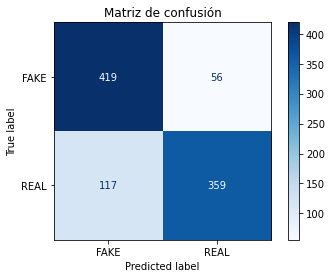

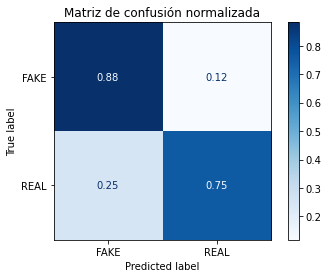

In [13]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]

confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['FAKE', 'REAL'])

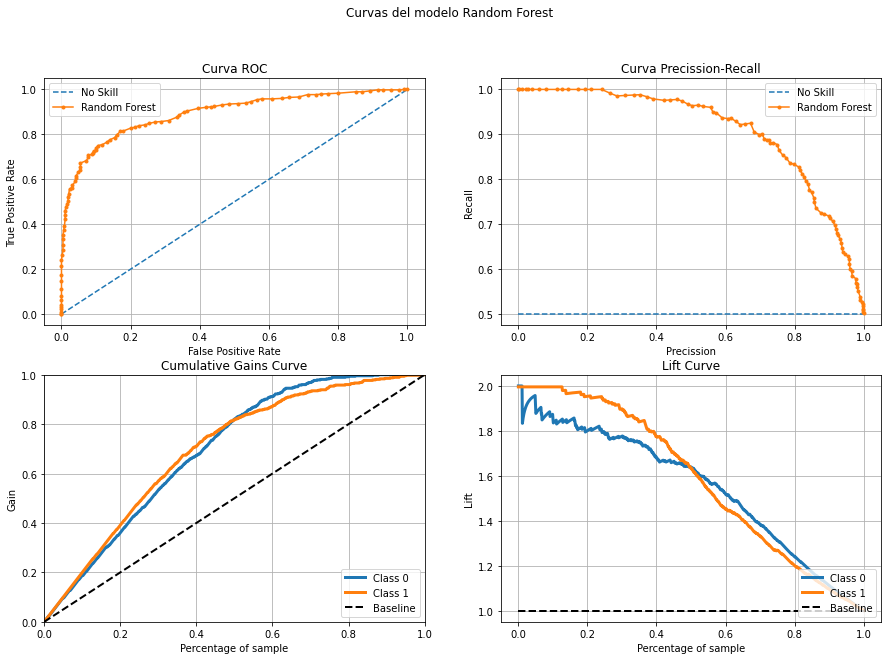

In [14]:
pred_prob = model.predict_proba(X_test)
model_curves_summary(Y_test, pred_prob, 'Random Forest')

### Naive Bayes (Multinomial)

In [16]:
model = MultinomialNB()

In [17]:
model.fit(X_train, Y_train)

MultinomialNB()

In [18]:
Y_pred = model.predict(X_test)

In [19]:
accuracy(Y_test, Y_pred)

0.8191377497371188

Matriz de confusión
[[387  88]
 [ 84 392]]
Matriz de confusión normalizada
[[0.81473684 0.18526316]
 [0.17647059 0.82352941]]


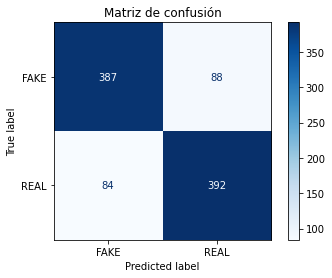

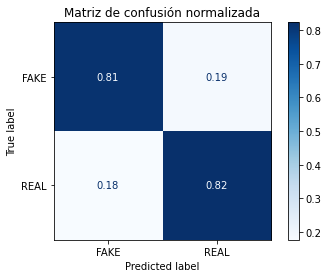

In [20]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]

confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['FAKE', 'REAL'])

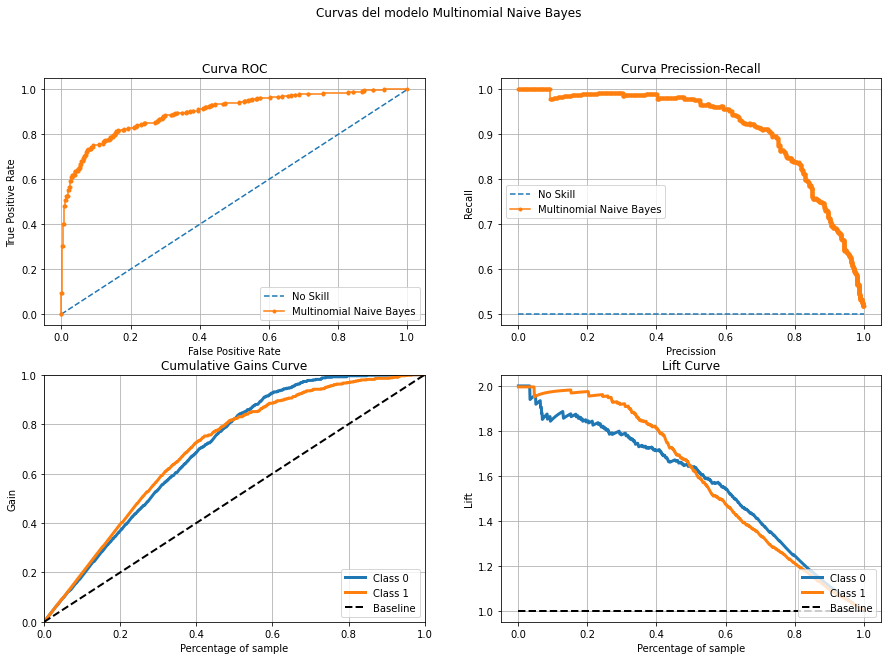

In [22]:
pred_prob = model.predict_proba(X_test)
model_curves_summary(Y_test, pred_prob, 'Multinomial Naive Bayes')

### XGBoost

In [24]:
model = XGBClassifier(use_label_encoder=False, eval_metric="error") # Default values

In [25]:
model.fit(X_train, Y_train)

C:\Users\carviagu\anaconda3\envs\NSD\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [26]:
Y_pred = model.predict(X_test)

In [27]:
accuracy(Y_test, Y_pred)

0.7981072555205048

Matriz de confusión
[[408  67]
 [125 351]]
Matriz de confusión normalizada
[[0.85894737 0.14105263]
 [0.26260504 0.73739496]]


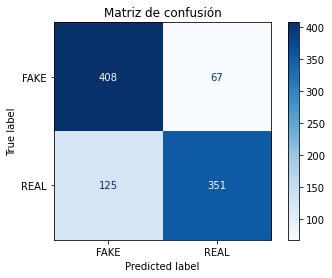

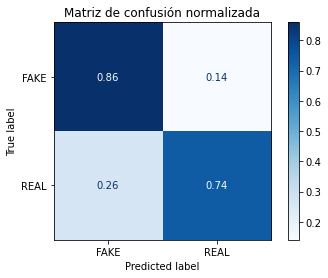

In [28]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['FAKE', 'REAL'])